In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [164]:
import matplotlib as mpl
import sympy as sp
import scipy as sc
from scipy import spatial
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.setrecursionlimit(10000)
import random
from math import *

In [419]:
CELL_R = 10 * 1e-6
CENTER_R = 5 * 1e-6
CELL_H = 1.5 * 1e-6

PARTICLE_D = 6 * 1e-9
MICROTUBULE_D = 25 * 1e-9

PARTICLE_CNT = 750
MICROTUBULE_CNT = 400

DIM = 3
DELTA_T = 1 * 1e-9

CENTER_X = 0
CENTER_Y = 0
CENTER_H = 0

ETA = 2.390041077895209e-06   # viscosity of cytoplasm in SI units (Pascal-seconds) at 293 K
C_B = 1.38e-23   # Boltzmann constant
T = 293         # Temperature in degrees Kelvin

DIFF_SIMPLE = C_B * T * 2/ (DIM * np.pi * ETA * PARTICLE_D) # [m^2 / s] 
print(DIFF_SIMPLE)
DIFF_WITH_MT = DIFF_SIMPLE / 3
print(DIFF_WITH_MT)
TRACK_SIZE = 10000

5.983412705976419e-08
1.9944709019921395e-08


In [355]:
#ОПУСТИТЬ ЦИЛИНДР

def generate_parametrization(size, min_r, max_r):
    if not size:
        return np.zeros((size, 4))
    
    rs = np.random.uniform(min_r, max_r, [size, 1])
    alphas = np.random.uniform(0, np.pi * 2, [size, 1])
    ps = (CELL_R - rs)**2
    hs = np.random.uniform(- CELL_H / 2 + rs, CELL_H / 2 - rs, [size, 1])
    
    return np.hstack([ps, alphas, hs, rs])

def parametrization_to_coords(values):
    ps = np.sqrt(values[:, 0:1])
    xs = ps * np.cos(values[:, 1:2])
    ys = ps * np.sin(values[:, 1:2])
    
    return np.hstack([xs, ys, values[:, 2:]])

def projection_on_sphere(values):
    if values.shape[0] == 0:
        return values
    length = np.sqrt((values * values).sum(axis = 1))
    return values[:,:DIM] / length.reshape(-1,1)

def generate_points(size, min_r, max_r):
    return parametrization_to_coords(generate_parametrization(int(size), min_r, max_r))

def generate_particles(part_cnt, radius):
    return generate_points(part_cnt, radius, radius)

def generate_displacement(particles, tree_microtubules, delta_time, diff_coef_simple, diff_coef_tubules, move_with_tubes):
    sigma_s = np.sqrt(2 * diff_coef_simple * delta_time)
    sigma_t = np.sqrt(2 * max(diff_coef_tubules, 0) * delta_time)
    
    need_to_move = check_for_in_center(particles)
    
    if diff_coef_tubules >= 0:
        sphere_particles = projection_on_sphere(particles)
        for (i, particle) in enumerate(sphere_particles):
            distance, index = tree_microtubules.query(particle[:DIM], 1)
            if (on_one_line(particles[i, :DIM], microtubules[index, :DIM])):
                move_with_tubes[i] = index
    
    delta_s = sigma_s[np.newaxis] * np.random.randn(particles.shape[0], DIM)
    delta_t = np.random.choice([1, -1]) * np.random.randn(particles.shape[0]) * sigma_t[np.newaxis]
    delta_s[np.logical_not(np.logical_and(need_to_move, move_with_tubes[:] < 0))] = 0
    delta_t[np.logical_not(np.logical_and(need_to_move, np.logical_not(move_with_tubes[:] < 0)))] = -1
    delta = delta_s
    for (i, delta_t_piece) in enumerate(delta_t):
        if (delta_t_piece > - 1/2):
            p = projection_on_sphere(np.array([microtubules[move_with_tubes[i]][:DIM]]))
            delta[i, :] = p * delta_t_piece
    return delta

def check_for_out_of_bounds(particles):
    first = particles[:, DIM] <= particles[:, DIM - 1]
    second = particles[:, DIM - 1] <= CELL_H / 2 - particles[:, DIM]
    second = particles[:, DIM - 1] >= - CELL_H / 2 + particles[:, DIM]
    third = np.linalg.norm(particles[:, :DIM - 1], axis = 1) <= CELL_R - particles[:, DIM]
    
    return np.logical_not(np.logical_and(first, np.logical_and(second, third)))

def check_for_in_center(particles):
    first = particles[:, DIM] <= particles[:, DIM - 1]
    second = particles[:, DIM - 1] <= CELL_H / 2 - particles[:, DIM]
    second = particles[:, DIM - 1] >= - CELL_H / 2 + particles[:, DIM]
    third = np.linalg.norm(particles[:, :DIM - 1], axis = 1) <= CENTER_R - particles[:, DIM]
    
    return np.logical_not(np.logical_and(first, np.logical_and(second, third)))

In [346]:
def generate_lines(size, radius):
    return generate_points(MICROTUBULE_CNT, radius, radius)

#def check_for_collisions(microtubules):
#    TODO

def on_one_line(a, b):
    a_proj, b_proj = projection_on_sphere(np.array([a, b]))
    a_copy = a * 10 ** 8
    cos_a = np.dot(a_proj, b_proj)
    dist = np.abs(1.0 - (cos_a ** 2)) * (a_copy * a_copy).sum()
    min_dist = ((PARTICLE_D + MICROTUBULE_D) / 2 * (10 ** 8)) ** 2
    return (dist <= min_dist)
    
def check_meeting(particles, tree_microtubules):
    met = np.full(particles.shape[0], -1, dtype = int)
    for (i, particle) in enumerate(particles):
        for (j, microtubule) in enumerate(tree_microtubules.data):
            if ((met[int(i)] < 0) & on_one_line(particle[:DIM], microtubule[:])):
                met[i] = j
    return met

In [388]:
def build_tracks_comp(particles, diff_coef_simple, microtubules, diff_coef_tubules):
    sphere_microtubules = projection_on_sphere(microtubules)
    tree_microtubules = spatial.KDTree(sphere_microtubules[:, :DIM])
    
    tracks = np.zeros([particles.shape[0], 0, DIM])
    average = 0
    number_in_center = 0
    step = 0
    meetings = np.full(particles.shape[0], -1)
    while ((number_in_center < particles.shape[0]) & (step < TRACK_SIZE)):     
        step += 1
        if step % 1000 == 0:
            print("STEP ", step)
        tracks = np.concatenate((tracks, np.zeros((tracks.shape[0], 1, tracks.shape[2]))), axis = 1)
        tracks[:, -1, :] = particles[:, :DIM]
            
        need_to_move = check_for_in_center(particles)
        deltas = generate_displacement(particles, tree_microtubules, DELTA_T, diff_coef_simple, diff_coef_tubules, meetings)
        
        particles[:, :DIM] += deltas[:, :]
        
        in_center = np.logical_not(check_for_in_center(particles))
        now_in_center = np.logical_and(need_to_move, in_center)
        average += np.sum(now_in_center) * (tracks.shape[1] * DELTA_T)
        number_in_center += np.sum(now_in_center)
        
        need_to_revert = check_for_out_of_bounds(particles)
        particles[:, :DIM][need_to_revert] -= deltas[need_to_revert]
        
    return tracks, average, number_in_center, meetings

def build_tracks_simple(particles, diff_coef_simple):
    tracks = np.zeros([particles.shape[0], 0, DIM])
    average = 0
    number_in_center = 0
    step = 0
    meetings = np.full(particles.shape[0], -1)
    while ((number_in_center < particles.shape[0]) & (step < TRACK_SIZE)):         
        step += 1
        if step % 1000 == 0:
            print("STEP ", step)
        tracks = np.concatenate((tracks, np.zeros((tracks.shape[0], 1, tracks.shape[2]))), axis = 1)
        tracks[:, -1, :] = particles[:, :DIM]
            
        need_to_move = check_for_in_center(particles)
        deltas = generate_displacement(particles, np.array([]), DELTA_T, diff_coef_simple, -1, meetings)
        particles[:, :DIM] += deltas[:, :]
        
        in_center = np.logical_not(check_for_in_center(particles))
        now_in_center = np.logical_and(need_to_move, in_center)
        average += np.sum(now_in_center) * (tracks.shape[1] * DELTA_T)
        number_in_center += np.sum(now_in_center)
        
        need_to_revert = check_for_out_of_bounds(particles)
        particles[:, :DIM][need_to_revert] -= deltas[need_to_revert]
        
    return tracks, average, number_in_center

In [400]:
from matplotlib.patches import Circle, Ellipse, Rectangle
from matplotlib.collections import PatchCollection

def plot_tracks(tracks, microtubules):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    ax.add_artist(plt.Circle((0, 0), CELL_R, color='b'))
    ax.add_artist(plt.Circle((0, 0), CENTER_R, color="lightskyblue"))
    ax.autoscale()
    for (i, track) in enumerate(tracks):
        ax.plot(track[::100, 0], track[::100, 1])
    for (i, line) in enumerate(microtubules):
        ax.plot(np.append(line[0], CENTER_X), np.append(line[1], CENTER_Y))
    plt.show()
    
def plot_microtubules(microtubules):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    ax.add_artist(plt.Circle((0, 0), CELL_R, color='b'))
    ax.add_artist(plt.Circle((0, 0), CENTER_R, color="lightskyblue"))
    for (i, line) in enumerate(microtubules):
        ax.plot(np.append(line[0], CENTER_X), np.append(line[1], CENTER_Y))
    plt.show()
    

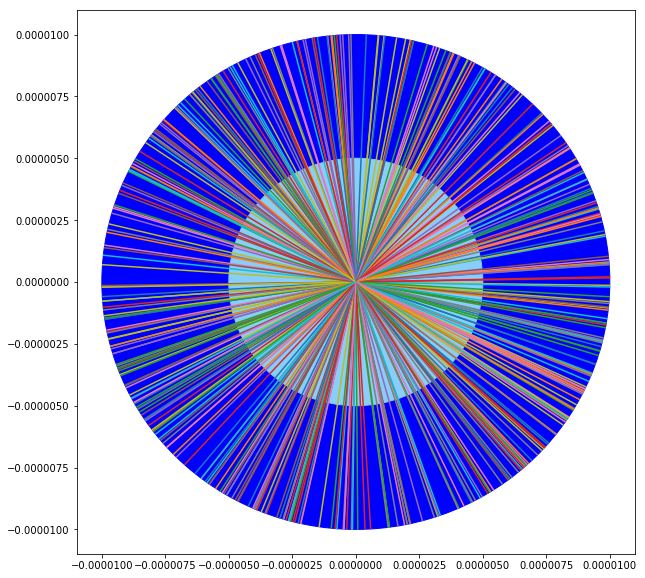

In [161]:
microtubules = generate_lines(MICROTUBULE_CNT, MICROTUBULE_D / 2)
plot_microtubules(microtubules)
tree_microtubules = spatial.KDTree(projection_on_sphere(microtubules))

particles_cnt:  500 microtubules_cnt:  400
Simple:
STEP  1000
STEP  2000
STEP  3000
STEP  4000
STEP  5000
STEP  6000
STEP  7000
STEP  8000
STEP  9000
STEP  10000
Calculation time: 

C:\Users\371\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


478.22153186798096
Average time: nan
Reached center: 0


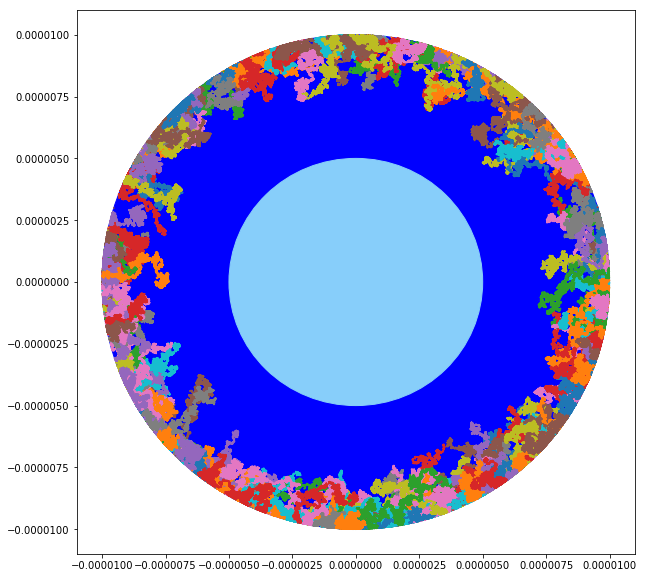

With microtubules:
STEP  1000
STEP  2000
STEP  3000
STEP  4000
STEP  5000
STEP  6000
STEP  7000
STEP  8000
STEP  9000
STEP  10000
Calculation time: 1813.7742278575897
Average time: nan
Reached center: 0
Met microtubule: 208
Met microtubule and reached center: 0


C:\Users\371\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


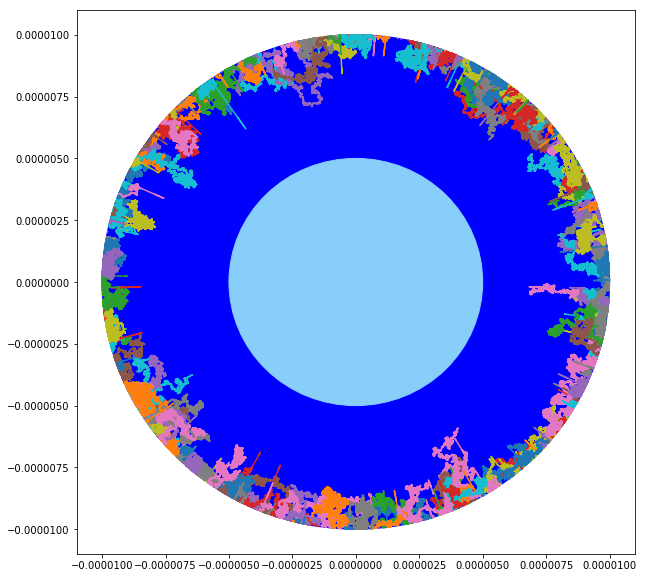

In [394]:
microtubules = generate_lines(MICROTUBULE_CNT, MICROTUBULE_D / 2)
particles = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)
particles_d = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)

print("particles_cnt: ", PARTICLE_CNT, "microtubules_cnt: ", MICROTUBULE_CNT)
print("Simple:")
start_time = time.time()
tracks, average_time, number_in_center = build_tracks_simple(particles, DIFF_SIMPLE)
end_time = time.time()
print("Calculation time:", end = ' ')
print(end_time - start_time)
print("Average time:", end = ' ')
print(average_time / number_in_center)
print("Reached center:", end = ' ')
print(number_in_center)
plot_tracks(tracks, np.array([]))

print("With microtubules:")
start_time = time.time()
tracks, average_time, number_in_center, meetings = build_tracks_comp(particles_d, DIFF_SIMPLE, microtubules, DIFF_WITH_MT)
end_time = time.time()
print("Calculation time:", end = ' ')
print(end_time - start_time)
print("Average time:", end = ' ')
print(average_time / number_in_center)
print("Reached center:", end = ' ')
print(number_in_center)
print("Met microtubule:", end = ' ')
print(tracks[meetings[:] >= 0].shape[0])
print("Met microtubule and reached center:", end = ' ')
print(tracks[np.logical_and(meetings[:] >= 0, np.logical_not(check_for_in_center(particles)))].shape[0])
plot_tracks(tracks, np.array([]))
# microtubules[meetings[:]])
#plot_tracks(tracks[check_meeting(particles, microtubules)[:] >= 0], microtubules[check_meeting(particles, microtubules)[:]])
#plot_microtubules(microtubules[check_meeting(particles, microtubules)[:]])

particles_cnt:  250 microtubules_cnt:  400
Simple:
STEP  1000
STEP  2000
STEP  3000
STEP  4000
STEP  5000
STEP  6000
STEP  7000
STEP  8000
STEP  9000
STEP  10000
Calculation time:

C:\Users\371\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


 243.9056191444397
Average time: nan
Reached center: 0


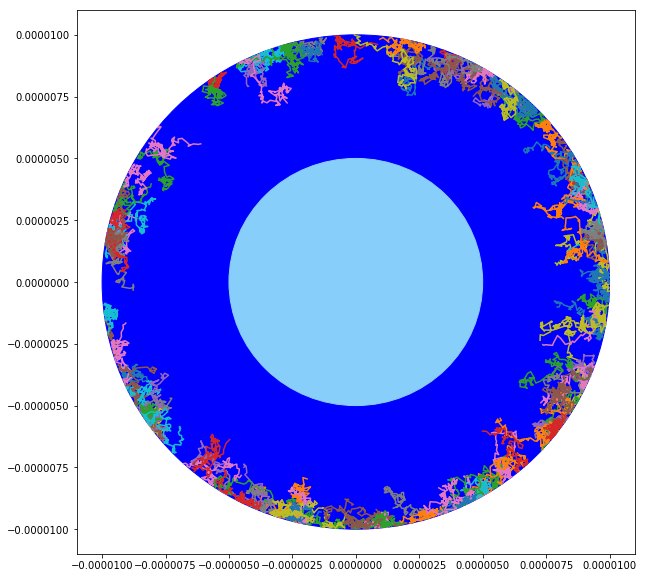

With microtubules:
STEP  1000
STEP  2000
STEP  3000
STEP  4000
STEP  5000
STEP  6000
STEP  7000
STEP  8000
STEP  9000
STEP  10000
Calculation time: 945.9800913333893
Average time:

C:\Users\371\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


 nan
Reached center: 0
Met microtubule: 121
Met microtubule and reached center: 0


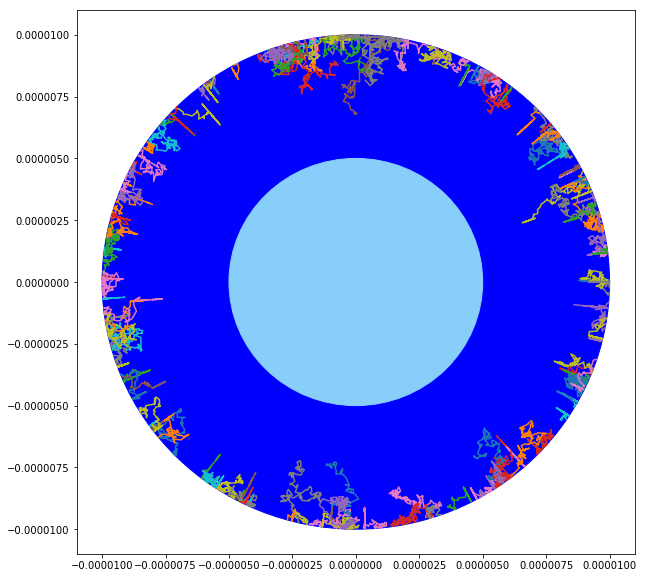

In [405]:
microtubules = generate_lines(MICROTUBULE_CNT, MICROTUBULE_D / 2)
particles = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)
particles_d = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)

print("particles_cnt: ", PARTICLE_CNT, "microtubules_cnt: ", MICROTUBULE_CNT)
print("Simple:")
start_time = time.time()
tracks, average_time, number_in_center = build_tracks_simple(particles, DIFF_SIMPLE)
end_time = time.time()
print("Calculation time:", end = ' ')
print(end_time - start_time)
print("Average time:", end = ' ')
print(average_time / number_in_center)
print("Reached center:", end = ' ')
print(number_in_center)
plot_tracks(tracks, np.array([]))

print("With microtubules:")
start_time = time.time()
tracks, average_time, number_in_center, meetings = build_tracks_comp(particles_d, DIFF_SIMPLE, microtubules, DIFF_WITH_MT)
end_time = time.time()
print("Calculation time:", end = ' ')
print(end_time - start_time)
print("Average time:", end = ' ')
print(average_time / number_in_center)
print("Reached center:", end = ' ')
print(number_in_center)
print("Met microtubule:", end = ' ')
print(tracks[meetings[:] >= 0].shape[0])
print("Met microtubule and reached center:", end = ' ')
print(tracks[np.logical_and(meetings[:] >= 0, np.logical_not(check_for_in_center(particles)))].shape[0])
plot_tracks(tracks, np.array([]))
# microtubules[meetings[:]])
#plot_tracks(tracks[check_meeting(particles, microtubules)[:] >= 0], microtubules[check_meeting(particles, microtubules)[:]])
#plot_microtubules(microtubules[check_meeting(particles, microtubules)[:]])

particles_cnt:  100 microtubules_cnt:  400
Simple:
STEP  1000
STEP  2000
STEP  3000
STEP  4000
STEP  5000
STEP  6000
STEP  7000
STEP  8000
STEP  9000
STEP  10000
STEP  11000
STEP  12000
STEP  13000
STEP  14000
STEP  15000
STEP  16000
STEP  17000
STEP  18000
STEP  19000
STEP  20000
STEP  21000
STEP  22000
STEP  23000
STEP  24000
STEP  25000
STEP  26000
STEP  27000
STEP  28000
STEP  29000
STEP  30000
STEP  31000
STEP  32000
STEP  33000
STEP  34000
STEP  35000
STEP  36000
STEP  37000
STEP  38000
STEP  39000
STEP  40000
STEP  41000
STEP  42000
STEP  43000
STEP  44000
STEP  45000
STEP  46000
STEP  47000
STEP  48000
STEP  49000
STEP  50000
STEP  51000
STEP  52000
STEP  53000
STEP  54000
STEP  55000
STEP  56000
STEP  57000
STEP  58000
STEP  59000
STEP  60000
STEP  61000
STEP  62000
STEP  63000
STEP  64000
STEP  65000
STEP  66000
STEP  67000
STEP  68000
STEP  69000
STEP  70000
STEP  71000
STEP  72000
STEP  73000
STEP  74000
STEP  75000
STEP  76000
STEP  77000
STEP  78000
STEP  79000
STEP  8000

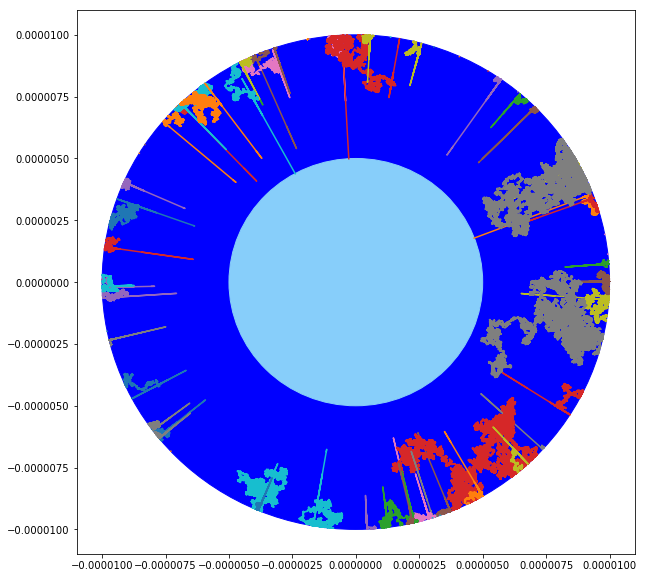

With microtubules:
STEP  1000
STEP  2000
STEP  3000
STEP  4000


KeyboardInterrupt: 

In [398]:
microtubules = generate_lines(MICROTUBULE_CNT, MICROTUBULE_D / 2)
particles = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)
particles_d = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)

print("particles_cnt: ", PARTICLE_CNT, "microtubules_cnt: ", MICROTUBULE_CNT)
print("Simple:")
start_time = time.time()
tracks, average_time, number_in_center = build_tracks_simple(particles, DIFF_SIMPLE)
end_time = time.time()
print("Calculation time:", end = ' ')
print(end_time - start_time)
print("Average time:", end = ' ')
print(average_time / number_in_center)
print("Reached center:", end = ' ')
print(number_in_center)
plot_tracks(tracks, np.array([]))

print("With microtubules:")
start_time = time.time()
tracks, average_time, number_in_center, meetings = build_tracks_comp(particles_d, DIFF_SIMPLE, microtubules, DIFF_WITH_MT)
end_time = time.time()
print("Calculation time:", end = ' ')
print(end_time - start_time)
print("Average time:", end = ' ')
print(average_time / number_in_center)
print("Reached center:", end = ' ')
print(number_in_center)
print("Met microtubule:", end = ' ')
print(tracks[meetings[:] >= 0].shape[0])
print("Met microtubule and reached center:", end = ' ')
print(tracks[np.logical_and(meetings[:] >= 0, np.logical_not(check_for_in_center(particles)))].shape[0])
plot_tracks(tracks, np.array([]))
# microtubules[meetings[:]])
#plot_tracks(tracks[check_meeting(particles, microtubules)[:] >= 0], microtubules[check_meeting(particles, microtubules)[:]])
#plot_microtubules(microtubules[check_meeting(particles, microtubules)[:]])

particles_cnt:  750 microtubules_cnt:  400
With microtubules:
STEP  1000
STEP  2000
STEP  3000
STEP  4000
STEP  5000
STEP  6000
STEP  7000
STEP  8000
STEP  9000
STEP  10000
Calculation time: 2737.1012868881226
Average time: nan


C:\Users\371\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Reached center: 0
Met microtubule: 309
Met microtubule and reached center: 0


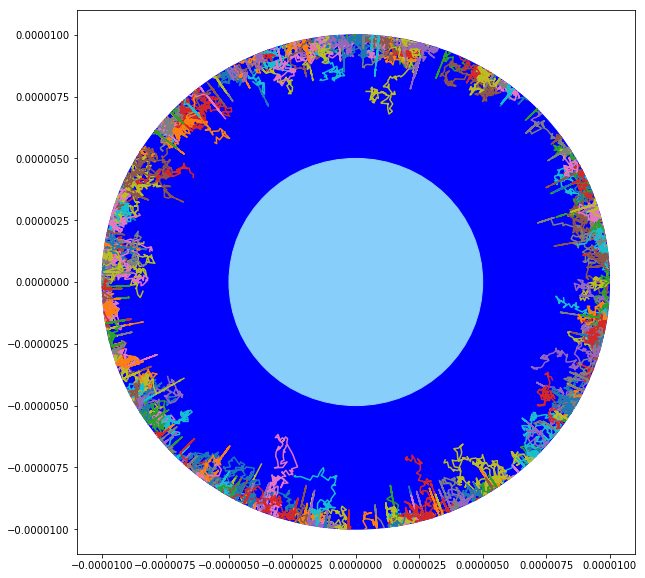

In [421]:
microtubules = generate_lines(MICROTUBULE_CNT, MICROTUBULE_D / 2)
particles = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)
particles_d = generate_particles(PARTICLE_CNT, PARTICLE_D / 2)

print("particles_cnt: ", PARTICLE_CNT, "microtubules_cnt: ", MICROTUBULE_CNT)
print("With microtubules:")
start_time = time.time()
tracks, average_time, number_in_center, meetings = build_tracks_comp(particles_d, DIFF_SIMPLE, microtubules, DIFF_WITH_MT)
end_time = time.time()
print("Calculation time:", end = ' ')
print(end_time - start_time)
print("Average time:", end = ' ')
print(average_time / number_in_center)
print("Reached center:", end = ' ')
print(number_in_center)
print("Met microtubule:", end = ' ')
print(tracks[meetings[:] >= 0].shape[0])
print("Met microtubule and reached center:", end = ' ')
print(tracks[np.logical_and(meetings[:] >= 0, np.logical_not(check_for_in_center(particles)))].shape[0])
plot_tracks(tracks, np.array([]))
# microtubules[meetings[:]])
#plot_tracks(tracks[check_meeting(particles, microtubules)[:] >= 0], microtubules[check_meeting(particles, microtubules)[:]])
#plot_microtubules(microtubules[check_meeting(particles, microtubules)[:]])